In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import statistics
import numpy as np
import random

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

students = pd.read_csv('stud_math.csv')

In [2]:
display(students.head(10))
students.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [3]:
students = students.rename(
    columns={'studytime, granular': 'studytime_granular'})

# Внимание

In [4]:
nomin_columns = ['Mjob', 'Fjob', 'reason', 'guardian']
num_columns = ['Fedu', 'Medu', 'traveltime', 'studytime',
               'studytime_granular', 'famrel', 'freetime', 'goout', 'health', 'failures']
# заполняем пропуски на other, где это уместно и на медиану для числовых значений
for columns in students.columns:
    if columns in nomin_columns:
        students[columns].fillna(value='other', inplace=True, axis=0)
    if columns in num_columns:
        median1 = students[columns].median()
        students[columns].fillna(value=median1, inplace=True, axis=0)

# функция для случайного заполнения колонок, в которых значения только yes и no
def fill_random(x):
    if pd.isnull(x):
        list = ['yes', 'no']
        return random.choice(list)
    else:
        return x

# заполнение пустых граф 
def fix_nomin(x):
    if x.strip == ' ':
        x = 'unknown'
    else:
        return x

In [5]:
pd.DataFrame(students.school.value_counts())  # всего 2 щколы во всем датасете

,school
GP,349
MS,46


In [6]:
# посмотрим, какое распределение по мальчикам/девочкам
pd.DataFrame(students.sex.value_counts())

,sex
F,208
M,187


In [7]:
# посмотрим, какое распределение по возрасту
pd.DataFrame(students.age.value_counts())

,age
16,104
17,98
18,82
15,82
19,24
20,3
22,1
21,1


count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

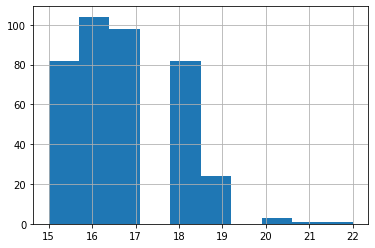

In [8]:
students.age.hist()
students.age.describe()

Как видно, у этого признака распределение без аномалий, выбросов нет

In [9]:
#  тип адреса ученика ('U' - городской, 'R' - за городом)
pd.DataFrame(students.address.value_counts())

,address
U,295
R,83


In [10]:
# заменим пропуски на nan
students.address = students.address.astype(str).apply(fix_nomin)

In [11]:
# большинство живут в городе, есть 17 человек, о которых нет данных
pd.DataFrame(students.address.value_counts())

,address
U,295
R,83
nan,17


In [12]:
#  размер семьи('LE3' <= 3, 'GT3' >3)
# заменим пропуски на None
students.famsize = students.famsize.astype(str).apply(fix_nomin)
# Проверим какое распределение по количеству членов семьи
pd.DataFrame(students.famsize.value_counts())

,famsize
GT3,261
LE3,107
nan,27


In [13]:
# статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
# заменим пропуски на None
students.Pstatus = students.Pstatus.astype(str).apply(fix_nomin)
# Проверим какое распределение по разведенным родителям
pd.DataFrame(students.Pstatus.value_counts())

,Pstatus
T,314
nan,45
A,36


In [14]:
# образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
students.Fedu.value_counts()

2.0     130
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: Fedu, dtype: int64

есть выброс, нужно от него избавиться, очевидно, что значение не может быть больше 4 

In [15]:
students.Fedu = students.Fedu.apply(
    lambda x: 4.0 if x == 40.0 else x)

In [16]:
students.Fedu.value_counts()

2.0    130
3.0     96
4.0     89
1.0     78
0.0      2
Name: Fedu, dtype: int64

<AxesSubplot:>

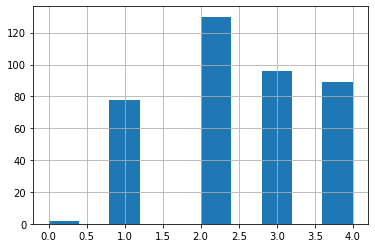

In [17]:
students.Fedu.hist()

In [18]:
# образование матерей (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
pd.DataFrame(students.Medu.value_counts())

,Medu
4.0,131
2.0,102
3.0,100
1.0,59
0.0,3


выбросов нет

<AxesSubplot:>

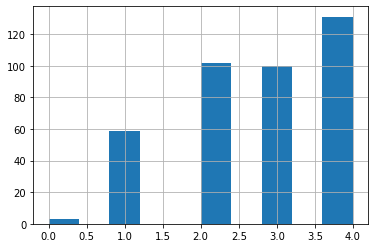

In [19]:
students.Medu.hist()

In [20]:
# Работа матерей
students.Mjob.value_counts()

other       152
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64

<AxesSubplot:title={'center':'Работа матерей'}>

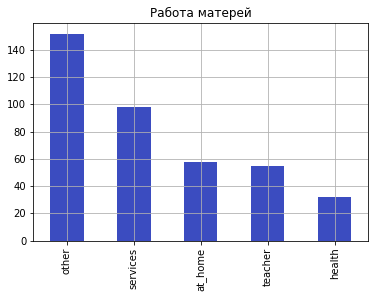

In [21]:
students['Mjob'].value_counts().plot(kind='bar',
                                     grid=True, colormap='coolwarm',
                                     title='Работа матерей')

In [22]:
# работа отцов
students.Fjob.value_counts()

other       233
services    102
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64

<AxesSubplot:title={'center':'Работа отцов'}>

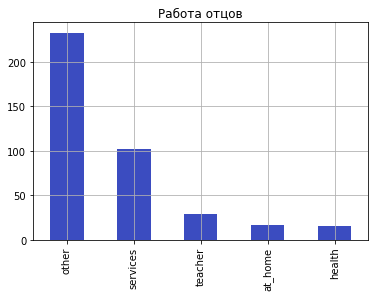

In [23]:
students['Fjob'].value_counts().plot(kind='bar',
                                     grid=True, colormap='coolwarm',
                                     title='Работа отцов')

In [24]:
# причина выбора школы 
#('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
students.reason.value_counts() 

course        137
home          104
reputation    103
other          51
Name: reason, dtype: int64

<AxesSubplot:>

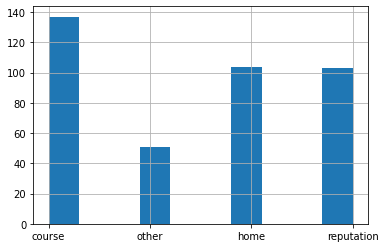

In [25]:
students.reason.hist()

In [26]:
students.guardian.value_counts()  # опекун

mother    250
father     86
other      59
Name: guardian, dtype: int64

<AxesSubplot:>

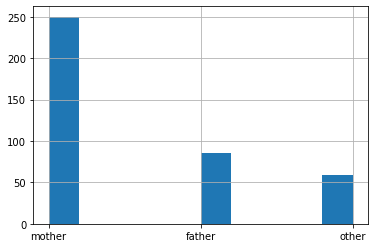

In [27]:
students.guardian.hist()

In [28]:
# время в пути до школы 1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.
students.traveltime.value_counts()

1.0    270
2.0     96
3.0     22
4.0      7
Name: traveltime, dtype: int64

<AxesSubplot:>

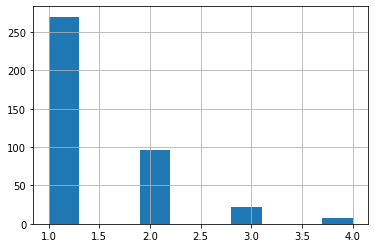

In [29]:
students.traveltime.hist()

In [30]:
# время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
students.studytime.value_counts()

2.0    201
1.0    103
3.0     64
4.0     27
Name: studytime, dtype: int64

<AxesSubplot:>

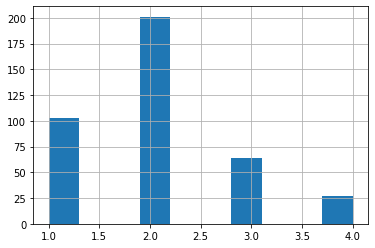

In [31]:
students.studytime.hist()

In [32]:
# количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
students.failures.value_counts()

0.0    315
1.0     49
2.0     16
3.0     15
Name: failures, dtype: int64

In [33]:
# есть очевидные ошибки ввода данных, присвоим этим значениям адекватные значения
def replace_failures(x):  # функция для заполнения пропусков на None
    if x == 2.0:
        return 1.0
    if x == 3.0:
        return 0.0
    else:
        return x

In [34]:
# количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
# функция случайного  заполнения пустых значений на 0,1,2,3
def func(x):
    if np.isnan(x):
        return random.randint(0,1,2,3)
    else:
        return x

students['failures'] = students['failures'].apply(func)
students.failures.value_counts()

0.0    315
1.0     49
2.0     16
3.0     15
Name: failures, dtype: int64

<AxesSubplot:>

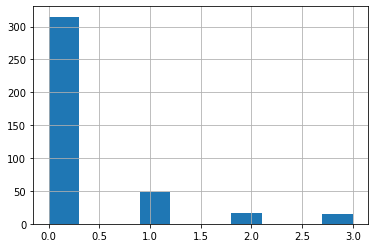

In [35]:
students.failures.hist()

In [36]:
# дополнительная образовательная поддержка (yes или no)
students.schoolsup.value_counts()

no     335
yes     51
Name: schoolsup, dtype: int64

In [37]:
students['schoolsup'] = students['schoolsup'].apply(fill_random)
students.schoolsup.value_counts()

no     343
yes     52
Name: schoolsup, dtype: int64

<AxesSubplot:title={'center':'Дополнительная образовательная поддержка'}>

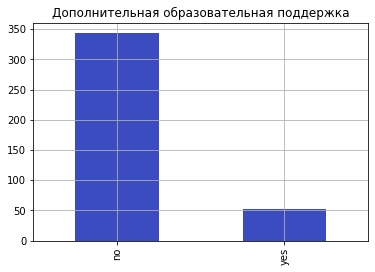

In [38]:
students['schoolsup'].value_counts().plot(kind='bar',
                                     grid=True, colormap='coolwarm',
                                     title='Дополнительная образовательная поддержка')

In [39]:
# семейная образовательная поддержка (yes или no)
students['famsup'] = students['famsup'].apply(fill_random)
students.famsup.value_counts()

yes    241
no     154
Name: famsup, dtype: int64

<AxesSubplot:title={'center':'Семейная образовательная поддержка'}>

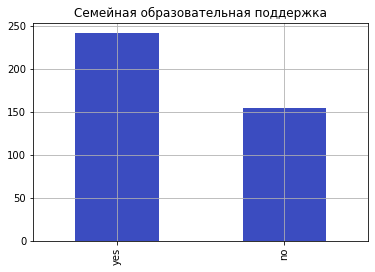

In [40]:
students['famsup'].value_counts().plot(kind='bar',
                                     grid=True, colormap='coolwarm',
                                     title='Семейная образовательная поддержка')

<AxesSubplot:title={'center':'Дополнительные платные занятия по математике'}>

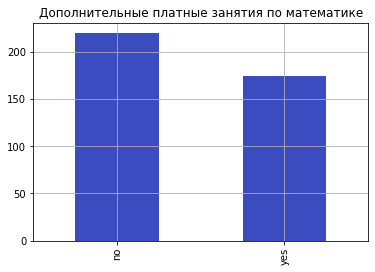

In [41]:
# дополнительные платные занятия по математике (yes или no)
students['paid'] = students['paid'].apply(fill_random)
students['paid'].value_counts().plot(kind='bar',
                                     grid=True, colormap='coolwarm',
                                     title='Дополнительные платные занятия по математике')

<AxesSubplot:title={'center':'Дополнительные внеучебные занятия'}>

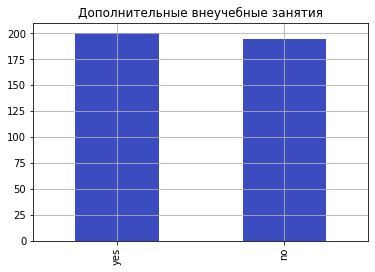

In [42]:
# дополнительные внеучебные занятия (yes или no)
students['activities'] = students['activities'].apply(fill_random)
students['activities'].value_counts().plot(kind='bar',
                                     grid=True, colormap='coolwarm',
                                     title='Дополнительные внеучебные занятия')

<AxesSubplot:title={'center':'Посещение детсокго сада'}>

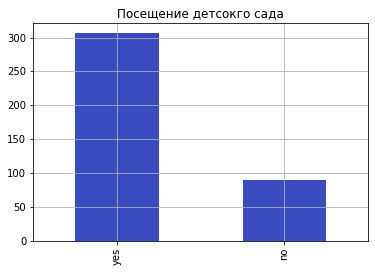

In [43]:
# посещал детский сад (yes или no)
students['nursery'] = students['nursery'].apply(fill_random)
students['nursery'].value_counts().plot(kind='bar',
                                     grid=True, colormap='coolwarm',
                                     title='Посещение детсокго сада')

<AxesSubplot:title={'center':'Намерение получить высшее образование'}>

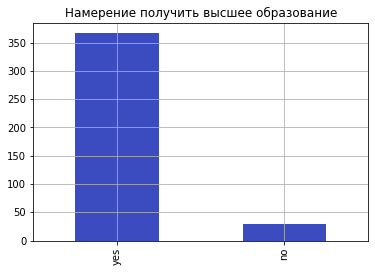

In [44]:
#  хочет получить высшее образование (yes или no)
students['higher'] = students['higher'].apply(fill_random)
students['higher'].value_counts().plot(kind='bar',
                                     grid=True, colormap='coolwarm',
                                     title='Намерение получить высшее образование')

<AxesSubplot:title={'center':'Наличие интернета'}>

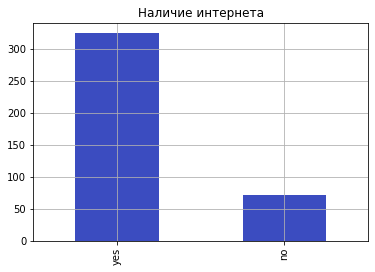

In [45]:
# наличие интернета дома (yes или no)
students['internet'] = students['internet'].apply(fill_random)
students['internet'].value_counts().plot(kind='bar',
                                     grid=True, colormap='coolwarm',
                                     title='Наличие интернета')

<AxesSubplot:title={'center':'Романтические отношения'}>

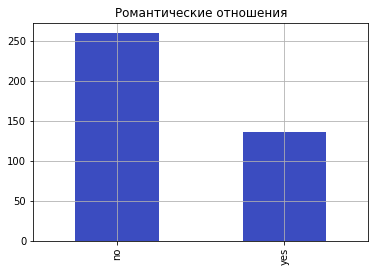

In [46]:
# в романтических отношениях (yes или no)
students['romantic'] = students['romantic'].apply(fill_random)
students['romantic'].value_counts().plot(kind='bar',
                                     grid=True, colormap='coolwarm',
                                     title='Романтические отношения')

In [47]:
# семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
students.famrel.value_counts()

 4.0    209
 5.0     99
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

In [48]:
# спишем отрицательное значение на опечатку и заменим его на положительное
students.famrel = students.famrel.apply(
    lambda x: 1.0 if x == -1.0 else x)

<AxesSubplot:title={'center':'Семейные отношения'}>

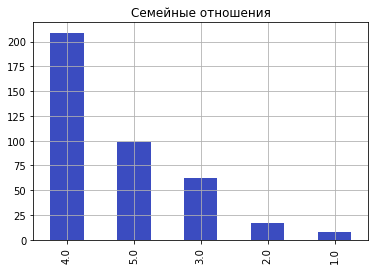

In [49]:
# семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
students['famrel'].value_counts().plot(kind='bar',
                                     grid=True, colormap='coolwarm',
                                     title='Семейные отношения')

<AxesSubplot:>

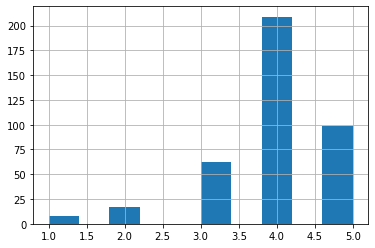

In [50]:
students.famrel.hist()

<AxesSubplot:title={'center':'Свободное время после школы'}>

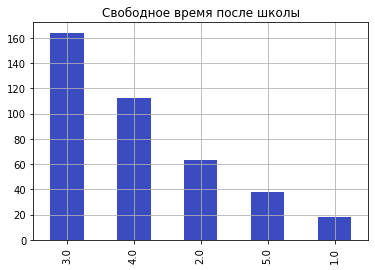

In [51]:
# свободное время после школы (от 1 - очень мало до 5 - очень мого)
students['freetime'].value_counts().plot(kind='bar',
                                     grid=True, colormap='coolwarm',
                                     title='Свободное время после школы')

In [52]:
# проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
students.goout.value_counts()

3.0    135
2.0    101
4.0     84
5.0     52
1.0     23
Name: goout, dtype: int64

<AxesSubplot:>

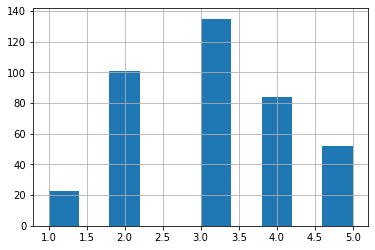

In [53]:
students.goout.hist()

In [54]:
# health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
students.health.value_counts()

5.0    138
3.0     89
4.0     78
1.0     47
2.0     43
Name: health, dtype: int64

<AxesSubplot:>

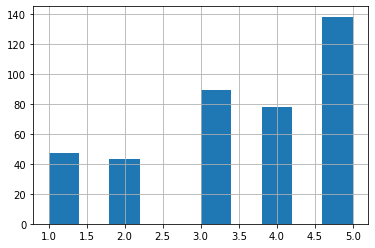

In [55]:
students.health.hist()

In [56]:
# absences — количество пропущенных занятий
students.absences.value_counts()

0.0      111
2.0       60
4.0       53
6.0       31
8.0       21
10.0      17
14.0      12
12.0      12
3.0        8
16.0       7
7.0        6
18.0       5
5.0        5
20.0       4
22.0       3
9.0        3
1.0        3
13.0       2
15.0       2
11.0       2
26.0       1
30.0       1
17.0       1
23.0       1
40.0       1
38.0       1
19.0       1
21.0       1
75.0       1
385.0      1
25.0       1
54.0       1
28.0       1
24.0       1
56.0       1
212.0      1
Name: absences, dtype: int64

<AxesSubplot:>

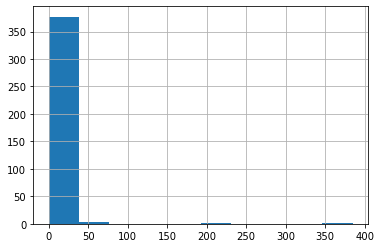

In [57]:
students.absences.hist()

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


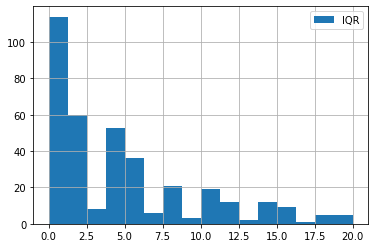

In [58]:
# в данных много выбросов, единичных случаев, когда у студентов много пропусков
# попробуем построить более показательный график
perc25 = students.absences.quantile(0.25)
perc75 = students.absences.quantile(0.75)
IQR = perc75 - perc25

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

students.absences.loc[students.absences.between(
    perc25 - 1.5*IQR,
    perc75 + 1.5*IQR)].hist(bins=16, label='IQR')

plt.legend()

In [59]:
# заменим выбросы на верхний квартиль
a = students.absences.median()
b = perc75 + 1.5*IQR
def replace_absences(x):  # функция для заполнения пропусков на None
    if x > perc75 + 1.5*IQR:
        return b
    else:
        return x
students.absences = students.absences.apply(replace_absences)

In [60]:
students.absences.value_counts()

0.0     111
2.0      60
4.0      53
6.0      31
8.0      21
20.0     21
10.0     17
12.0     12
14.0     12
3.0       8
16.0      7
7.0       6
18.0      5
5.0       5
1.0       3
9.0       3
13.0      2
15.0      2
11.0      2
19.0      1
17.0      1
Name: absences, dtype: int64

In [61]:
students.studytime_granular.value_counts() # непонятное мне значение

-6.0     201
-3.0     103
-9.0      64
-12.0     27
Name: studytime_granular, dtype: int64

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

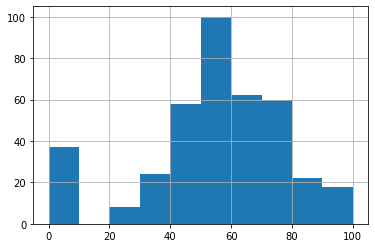

In [62]:
students.score.hist()
students.score.describe()
# система стобальная, выбросов нет, есть нулевые значения

In [63]:
students = students[students.score > 0] # исключим нулевые значения

count    352.000000
mean      57.755682
std       16.200928
min       20.000000
25%       45.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

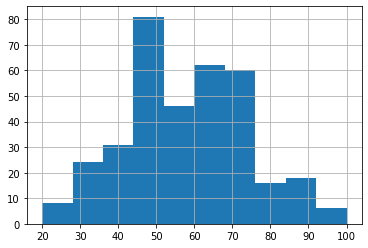

In [64]:
students.score.hist()
students.score.describe()

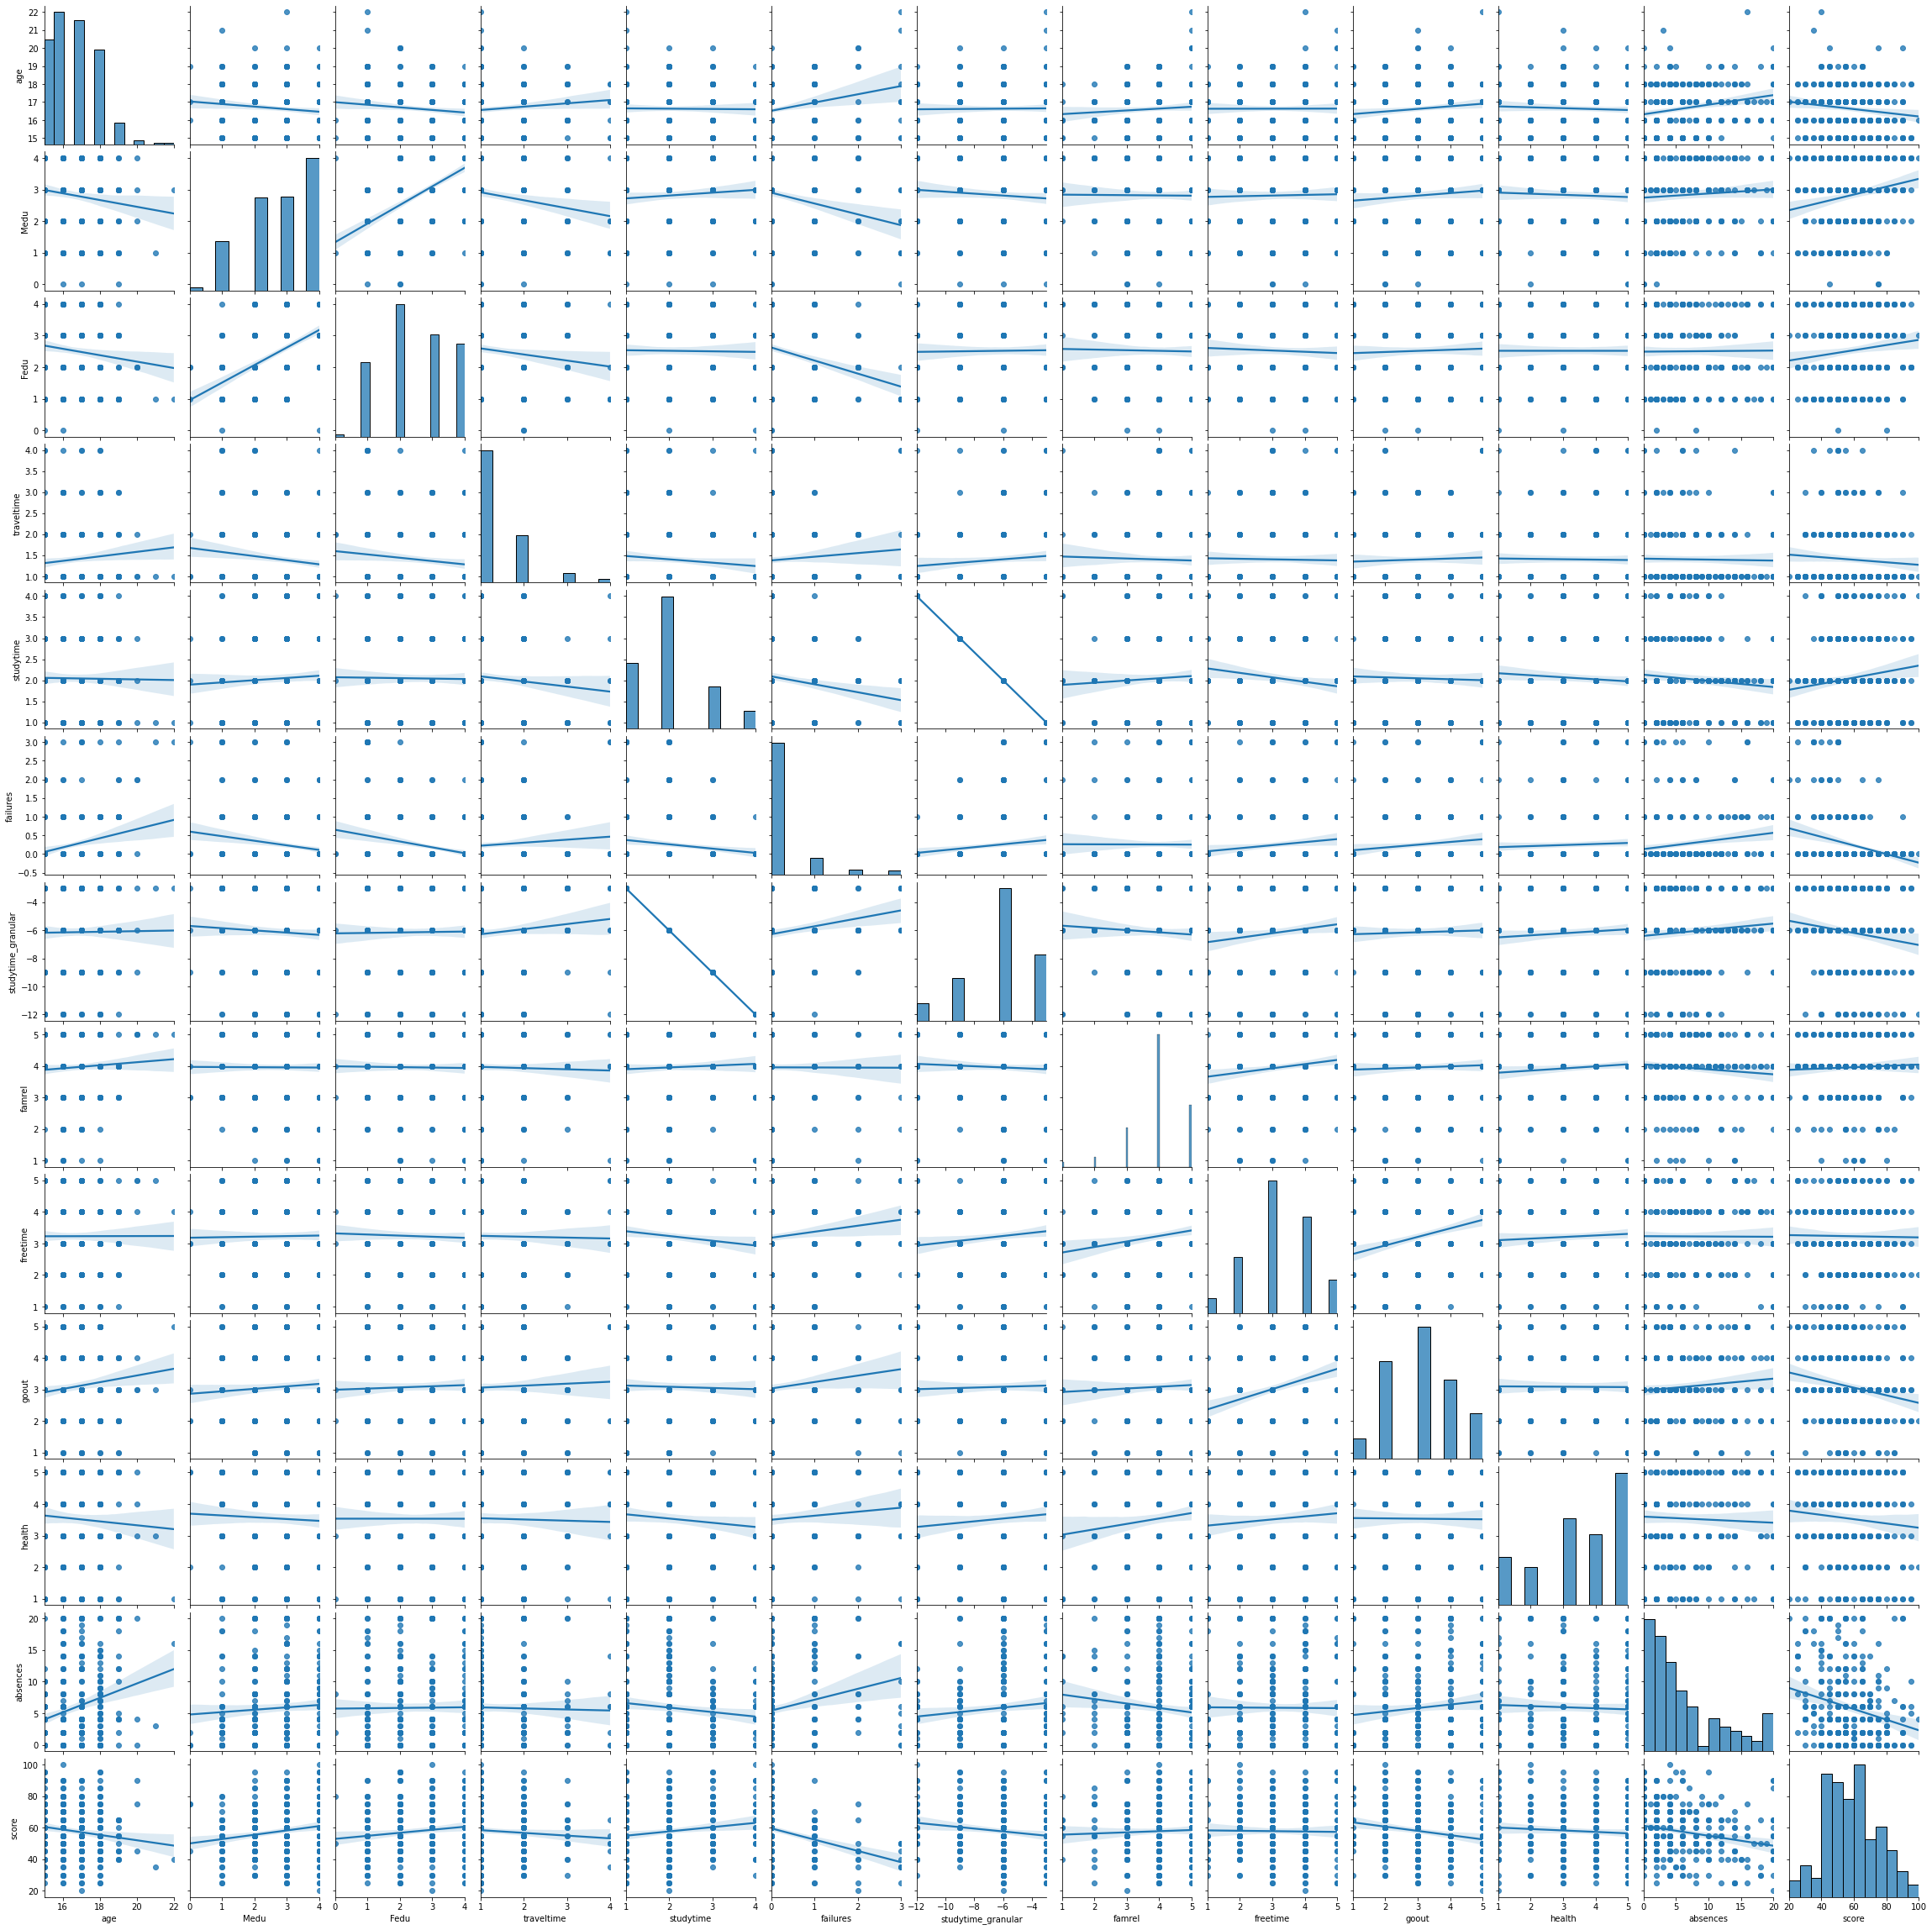

In [65]:
sns.pairplot(students, kind = 'reg')

In [66]:
students.corr()

,age,Medu,Fedu,traveltime,studytime,failures,studytime_granular,famrel,freetime,goout,health,absences,score
age,1.000000,-0.123376,-0.120860,0.099530,-0.011270,0.236688,0.011270,0.070259,0.001563,0.123597,-0.055674,0.246203,-0.131542
Medu,-0.123376,1.000000,0.572677,-0.157040,0.069187,-0.205450,-0.069187,-0.006627,0.018944,0.078894,-0.044754,0.070190,0.184533
Fedu,-0.120860,0.572677,1.000000,-0.123213,-0.013838,-0.254655,0.013838,-0.016254,-0.037676,0.036082,-0.000397,0.009521,0.125396
traveltime,0.099530,-0.157040,-0.123213,1.000000,-0.098219,0.083732,0.098219,-0.030175,-0.018856,0.038845,-0.019123,-0.019462,-0.072435
studytime,-0.011270,0.069187,-0.013838,-0.098219,1.000000,-0.147551,-1.000000,0.054535,-0.126369,-0.029597,-0.080160,-0.102106,0.139605
failures,0.236688,-0.205450,-0.254655,0.083732,-0.147551,1.000000,0.147551,-0.003306,0.124534,0.122500,0.059584,0.193591,-0.286925
studytime_granular,0.011270,-0.069187,0.013838,0.098219,-1.000000,0.147551,1.000000,-0.054535,0.126369,0.029597,0.080160,0.102106,-0.139605
famrel,0.070259,-0.006627,-0.016254,-0.030175,0.054535,-0.003306,-0.054535,1.000000,0.152357,0.043993,0.106954,-0.105264,0.039036
freetime,0.001563,0.018944,-0.037676,-0.018856,-0.126369,0.124534,0.126369,0.152357,1.000000,0.294294,0.069643,-0.005634,-0.014731
goout,0.123597,0.078894,0.036082,0.038845,-0.029597,0.122500,0.029597,0.043993,0.294294,1.000000,-0.007619,0.102501,-0.179913


#### Все переменные слабоскоррелированны с оценкой, но все же зависимость есть:
Наблюдаем отрицательную корреляцию параметра age и score, чем старше ученик, тем сложнее учиться, 
а так же плохо влияет на оценку долгая дорога до школы traveltime, много свободного времени и отдыха freetime и goout, 
а так же большое количество пропусков absences, что логично. 
Отрицательная корреляция studytime_granular и score говорит о том, что чем меньше это значение, тем выше оценка
Интересно, что чем хуже здоровье health, тем выше оценка, что ожидаемо, ведь эти ученики мало гуляют
Чем образованнее родители Medu и Fedu, тем лучше оценки их детей, а так же чем больше студенты учатся studytime 
и чем лучше отношения с родителями famrel, тем лучше оценки
Корреляция studytime_granular и studytime по модулю равна 1, оставим только одно из значений (studytime)

In [68]:
def get_boxplot(column):    
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=students.loc[students.loc[:, column].isin(students.loc[:, column].value_counts().index[:30])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

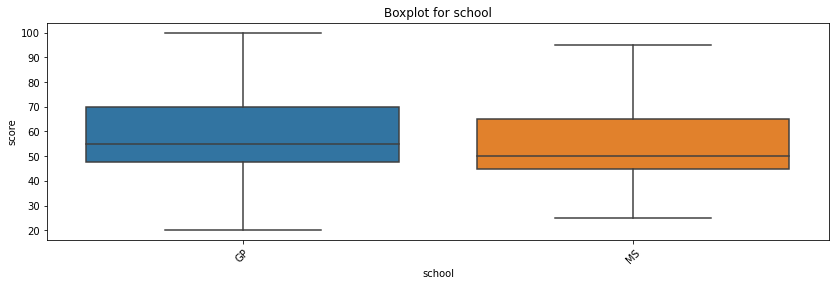

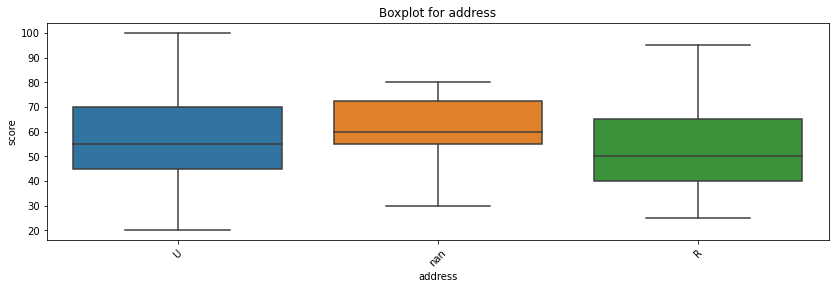

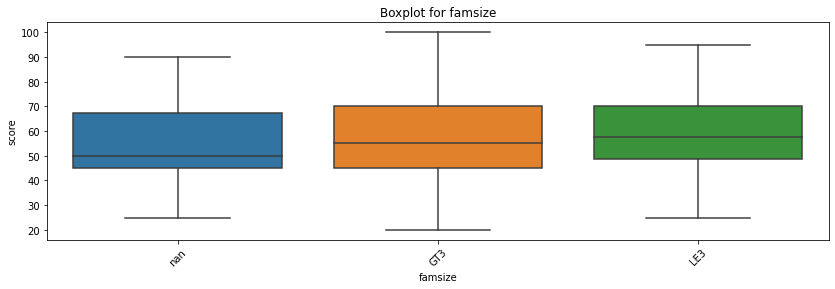

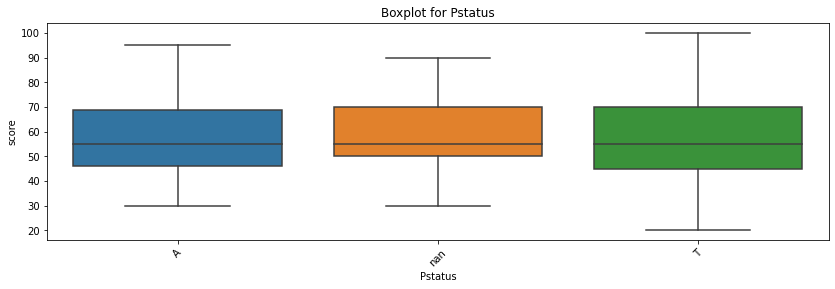

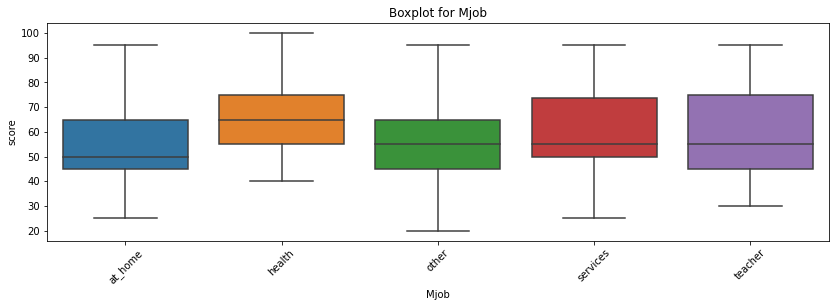

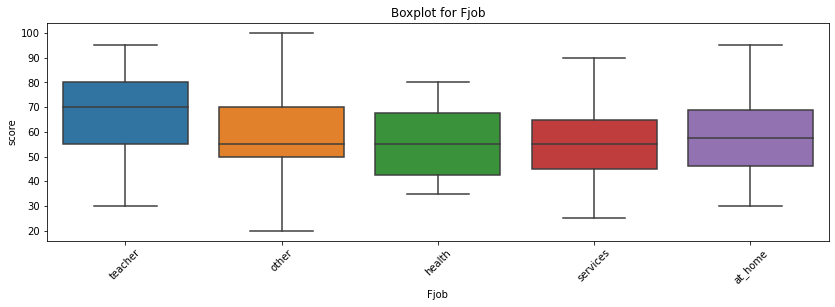

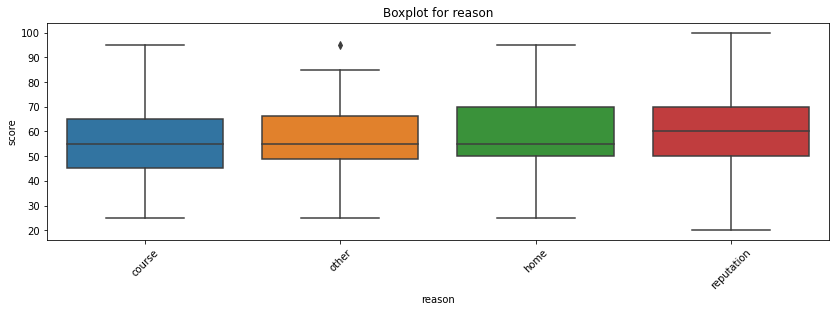

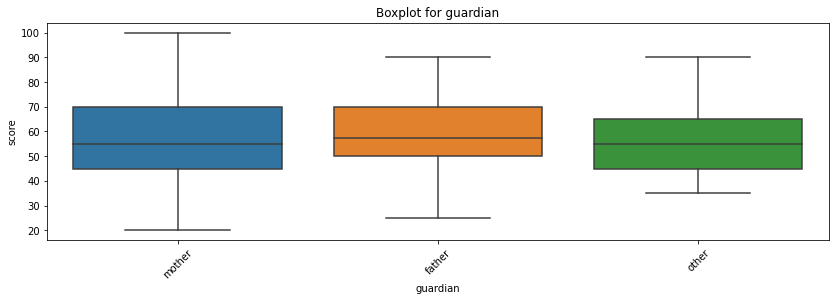

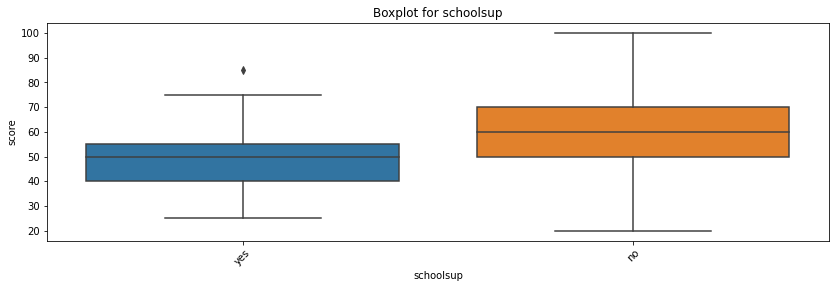

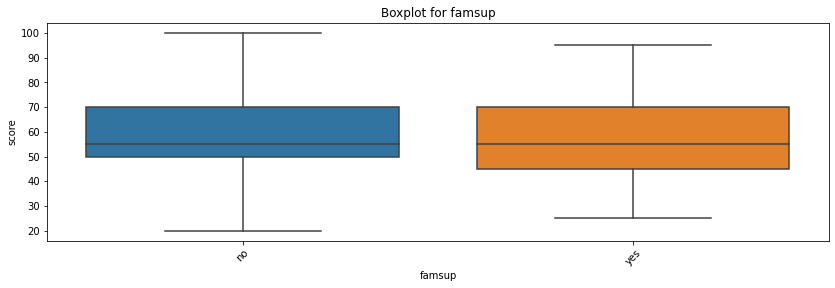

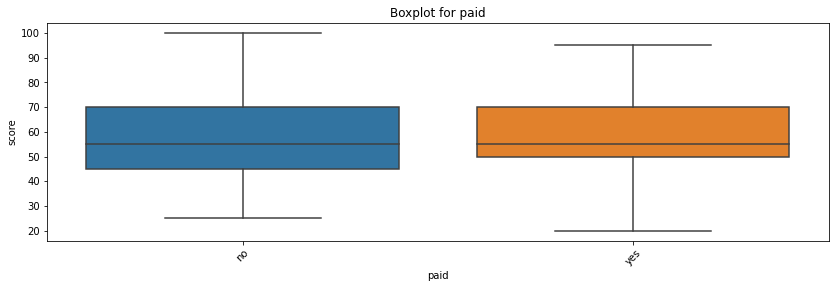

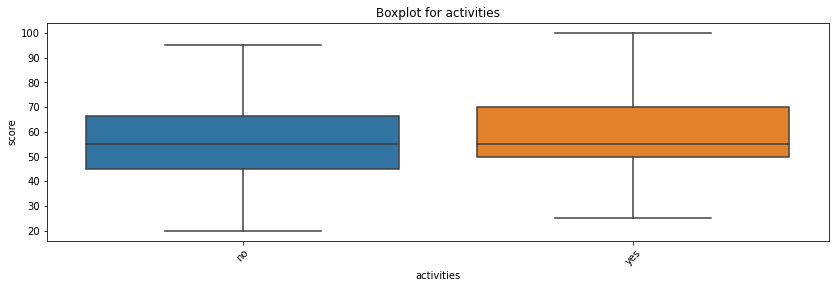

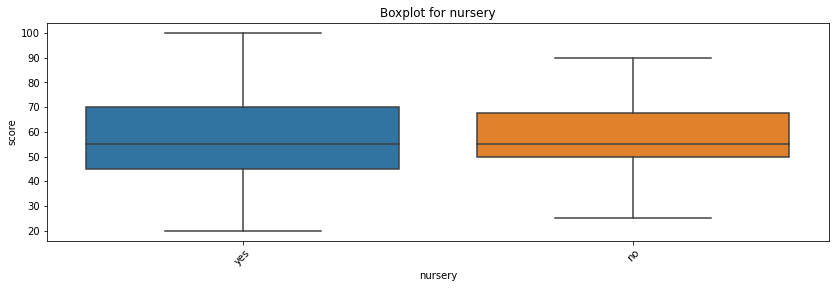

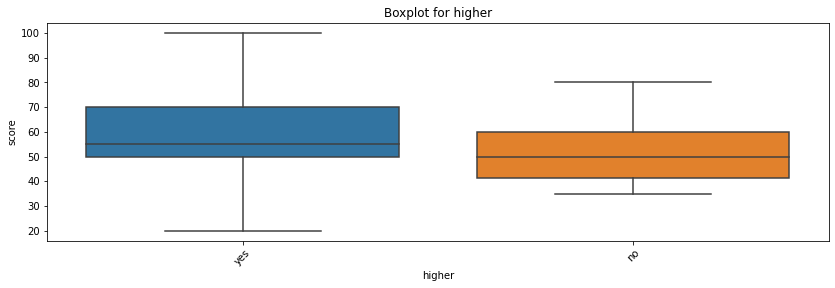

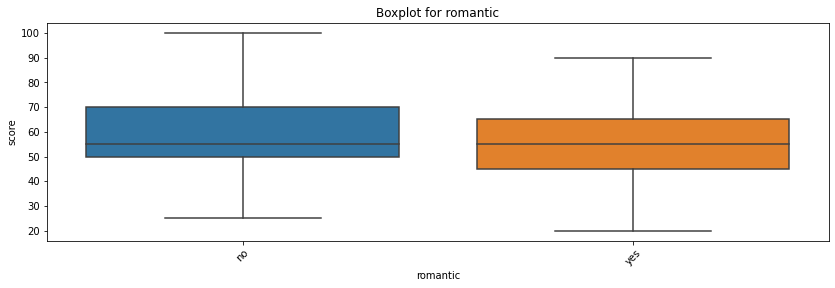

In [69]:
for col in ['school', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup',
            'famsup', 'paid', 'activities', 'nursery', 'higher', 'romantic']:
    get_boxplot(col)

судя по графикам, на оценку влияют только работа матерей и отцов и дополнительная образовательная поддержка, причем при её отсутствии, оценки выше

In [70]:
def get_stat_dif(column):
    cols = students.loc[:, column].value_counts().index[:30]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(students.loc[students.loc[:, column] == comb[0], 'score'], 
                        students.loc[students.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [71]:
for col in ['school', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup',
            'famsup', 'paid', 'activities', 'nursery', 'higher', 'romantic']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки Fjob
Найдены статистически значимые различия для колонки schoolsup


Статистически значимые различия дя колоки address появились только птому, что мы выдлили пустые значения в отдельное,
на самом деле, судя по боксплотам для городских и деревенских, это не влияет на оценку
Зато влияет работа отцов и матерей, причем оценки выше, если отец учитель, а мать работает в медицине

In [72]:
# оставим в датасете только переменные, которые влияют на оценку
students_for_model = students.loc[:, ['Mjob', 'Fjob', 'schoolsup', 'age', 'Medu', 'Fedu', 'traveltime', 'studytime',
                                      'failures', 'famrel', 'goout', 'health', 'absences']]
students_for_model.head()

,Mjob,Fjob,schoolsup,age,Medu,Fedu,traveltime,studytime,failures,famrel,goout,health,absences
0,at_home,teacher,yes,18,4.0,4.0,2.0,2.0,0.0,4.0,4.0,3.0,6.0
1,at_home,other,no,17,1.0,1.0,1.0,2.0,0.0,5.0,3.0,3.0,4.0
2,at_home,other,yes,15,1.0,1.0,1.0,2.0,3.0,4.0,2.0,3.0,10.0
3,health,other,no,15,4.0,2.0,1.0,3.0,0.0,3.0,2.0,5.0,2.0
4,other,other,no,16,3.0,3.0,1.0,2.0,0.0,4.0,2.0,5.0,4.0
